In [1]:
import numpy as np

In [4]:
collision = np.load('.data/Time_series_colisao.npz')
display(collision.keys())
spreading = np.load('.data/Time_series_espalhamento.npz')
display(spreading.keys())

KeysView(NpzFile '.data/Time_series_colisao.npz' with keys: TS, Re, We, B)

KeysView(NpzFile '.data/Time_series_espalhamento.npz' with keys: TS, Re, We, Fr, V0...)

# Colisão | Collision

In [76]:
collision_timesteps_raw = collision['TS']
display(collision_timesteps_raw.shape)

(72, 1000, 5)

In [180]:
collision_timesteps = collision_timesteps_raw[:, :, 0]
collision_timesteps = collision_timesteps.T
display(collision_timesteps.shape)
# display(transformed_timesteps.shape)
# display(transformed_timesteps)

(1000, 72)

In [198]:
from typing import Literal
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer, Normalizer


chosen_scaler: Literal[
    'StandardScaler',
    'MinMaxScaler',
    'RobustScaler',
    'MaxAbsScaler',
    'QuantileTransformer',
    'PowerTransformer',
    'Normalizer'
] = 'MinMaxScaler'
scaler = eval(chosen_scaler)()
collision_timesteps = scaler.fit_transform(collision_timesteps)
display(collision_timesteps)

array([[0.7663925 , 1.        , 0.8383797 , ..., 0.94486355, 0.8490085 ,
        0.91872075],
       [0.73728674, 0.96403453, 0.80611169, ..., 0.90808698, 0.81639526,
        0.88302532],
       [0.70878527, 0.92863582, 0.77431196, ..., 0.87176337, 0.78424121,
        0.84795542],
       ...,
       [0.41313257, 0.56541295, 0.49404039, ..., 0.53643569, 0.46643839,
        0.52467149],
       [0.41292763, 0.56553295, 0.49645165, ..., 0.53637427, 0.46928214,
        0.52364095],
       [0.41272737, 0.56566669, 0.49873125, ..., 0.53614702, 0.47199781,
        0.52232614]])

In [199]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(72, 36),
            nn.Sigmoid(),
            nn.Linear(36, 8),
            nn.Sigmoid(),
            # nn.Linear(48, 8),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 36),
            nn.Sigmoid(),
            nn.Linear(36, 72),
            nn.Sigmoid(),
            # nn.Linear(48, 72),
        )
        # Summary
        print('Encoder:')
        print(self.encoder)
        print('Decoder:')
        print(self.decoder)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [200]:
# Training the autoencoder
import torch
import torch.optim as optim
from torch.autograd import Variable

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
training_data = collision_timesteps[:800]
training_data = Variable(torch.from_numpy(training_data).float())
batch_size = 4
model.train()
for epoch in range(200):
    epoch_loss = 0.
    for i in range(0, training_data.size(0), batch_size):
        input_data = training_data[i:i + batch_size]
        output_data = model(input_data)
        loss = criterion(output_data, input_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        batch_loss /= batch_size
        epoch_loss += batch_loss
        if epoch % 100 == 0:
            print('Epoch %d, batch %d, mean loss: %.4f' % (epoch, i, batch_loss))
    if epoch % 100 == 0:
        epoch_loss /= training_data.size(0) // batch_size
        print('Epoch %d, loss: %.4f' % (epoch, epoch_loss))

Encoder:
Sequential(
  (0): Linear(in_features=72, out_features=36, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=36, out_features=8, bias=True)
  (3): Sigmoid()
)
Decoder:
Sequential(
  (0): Linear(in_features=8, out_features=36, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=36, out_features=72, bias=True)
  (3): Sigmoid()
)
Epoch 0, batch 0, mean loss: 0.0351
Epoch 0, batch 4, mean loss: 0.0114
Epoch 0, batch 8, mean loss: 0.0028
Epoch 0, batch 12, mean loss: 0.0050
Epoch 0, batch 16, mean loss: 0.0135
Epoch 0, batch 20, mean loss: 0.0248
Epoch 0, batch 24, mean loss: 0.0367
Epoch 0, batch 28, mean loss: 0.0487
Epoch 0, batch 32, mean loss: 0.0592
Epoch 0, batch 36, mean loss: 0.0604
Epoch 0, batch 40, mean loss: 0.0563
Epoch 0, batch 44, mean loss: 0.0486
Epoch 0, batch 48, mean loss: 0.0392
Epoch 0, batch 52, mean loss: 0.0302
Epoch 0, batch 56, mean loss: 0.0226
Epoch 0, batch 60, mean loss: 0.0164
Epoch 0, batch 64, mean loss: 0.0115
Epoch 0, batch 68, mean loss: 

In [201]:
# testing
model.eval()
testing_data = collision_timesteps[800:]
testing_data = Variable(torch.from_numpy(testing_data).float())
output_data = model(testing_data)

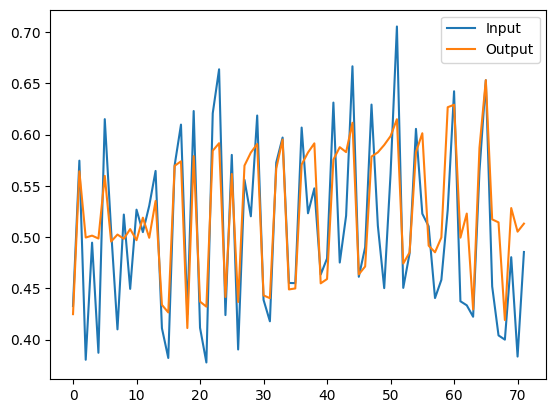

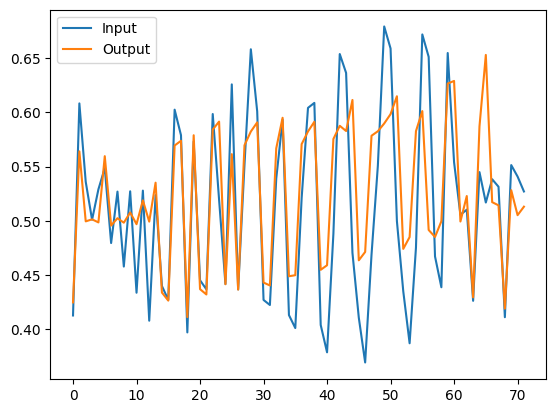

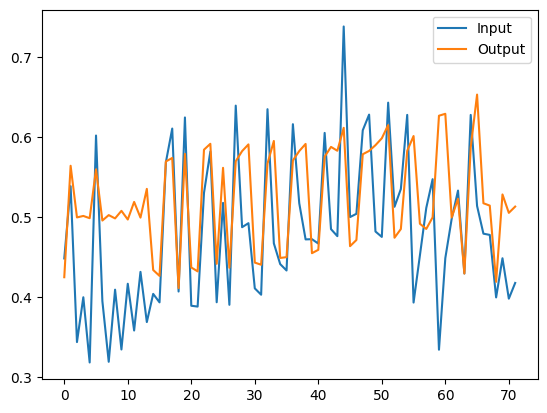

In [202]:
output_data = output_data.data.numpy()
# output_data = scaler.inverse_transform(output_data)
testing_data = testing_data.data.numpy()
# testing_data = scaler.inverse_transform(testing_data)
# 3 random samples
import matplotlib.pyplot as plt
import random

for i in range(3):
    idx = random.randint(0, testing_data.shape[0])
    plt.plot(testing_data[idx, :], label='Input')
    plt.plot(output_data[idx, :], label='Output')
    plt.legend()
    plt.show()

##### Demonstrating that this transpose makes sense

In [68]:
# Let's test if this is correct
# Suppose we have tree simulations with 2 components each
# We have 3 timesteps
# First component is linear, second is quadratic
# First simulation starts with 1
# Second simulation starts with 2
# Third simulation starts with 3
# Therefore, first simulation first component is [1, 2, 3]
# Second simulation first component is [2, 3, 4]
# Third simulation first component is [3, 4, 5]
# First simulation second component is [1, 4, 9]
# Second simulation second component is [4, 9, 16]
# Third simulation second component is [9, 16, 25]
# Therefore, first timestep is [[1, 2, 3], [1, 4, 9]]
first_simulation = np.array([[1, 1], [2, 4], [3, 9]])
second_simulation = np.array([[2, 4], [3, 9], [4, 16]])
third_simulation = np.array([[3, 9], [4, 16], [5, 25]])
timesteps = np.array([first_simulation, second_simulation, third_simulation])
shape = timesteps.shape
display(shape)
transformed_timesteps = timesteps.transpose(1, 0, 2).reshape(shape[1], shape[0] * shape[2])
display(transformed_timesteps)

(3, 3, 2)

array([[ 1,  1,  2,  4,  3,  9],
       [ 2,  4,  3,  9,  4, 16],
       [ 3,  9,  4, 16,  5, 25]])